In [158]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import numpy as np
import osmnx as ox
import contextily as ctx
from fiona.crs import from_epsg
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import time
import itertools

In [2]:


# read game_grid as GeoDataFrame and correct CRS (Coordinate Reference System)
game_grid = gpd.read_file('grid/game_grid_all_stats.shp')
game_grid.crs='epsg:3857'
#game_grid



In [3]:

shelters = gpd.read_file('facilities/shelters.shp')
airfields = gpd.read_file('facilities/airfields.shp')

In [4]:
game_grid

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,Health,Utility,Transport,population,SVI,geometry
0,19TBH7264,BH,19T,272000mE,4764000mN,19TBH76,0.042522,0.042522,0.000110,-71.791007,42.999142,10,7,3,15.0,0.2113,"POLYGON ((-7991033.712 5311179.522, -7992397.7..."
1,19TBH7364,BH,19T,273000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.778753,42.999441,10,7,3,11.0,0.2113,"POLYGON ((-7989669.690 5311224.829, -7991033.7..."
2,19TBH7464,BH,19T,274000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.766499,42.999738,10,7,3,14.0,0.2113,"POLYGON ((-7988305.646 5311269.937, -7989669.6..."
3,19TBH7564,BH,19T,275000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.754245,43.000033,10,7,3,21.0,0.2113,"POLYGON ((-7986941.582 5311314.845, -7988305.6..."
4,19TBH7664,BH,19T,276000mE,4764000mN,19TBH76,0.042524,0.042524,0.000110,-71.741990,43.000328,10,7,3,28.0,0.0336,"POLYGON ((-7985577.497 5311359.555, -7986941.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,19TDG1600,DG,19T,416000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-70.001238,41.551809,10,5,3,0.0,0.0495,"POLYGON ((-7791827.195 5093415.199, -7793161.7..."
15886,19TDG1700,DG,19T,417000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-69.989249,41.551913,10,5,3,0.0,0.0495,"POLYGON ((-7790492.658 5093430.539, -7791827.1..."
15887,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,10,5,3,0.0,0.0495,"POLYGON ((-7793146.168 5092060.201, -7794480.5..."
15888,19TDF1699,DF,19T,416000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.001099,41.542803,10,5,3,0.0,0.0495,"POLYGON ((-7791811.823 5092075.720, -7793146.1..."


In [5]:


game_grid = game_grid.to_crs('epsg:4269') # convert geometry to latitude, longitude to match centroid location
game_grid['EAST'] = pd.to_numeric(game_grid['EASTING'].str[:-5]) # calculate grid east position from easting and ignore trailing 000mE
game_grid['NORTH'] = pd.to_numeric(game_grid['NORTHING'].str[:-5]) # calculate grid north position from northing and ignore trailing 000mN
game_grid_pos = game_grid.set_index(['EAST', 'NORTH']) # set index to grid position for seperate dataframe
game_grid = game_grid.set_index('MGRS') # use MGRS as main indexing method (Military Grid Reference System)

 # time entire cell to show performance
G = nx.Graph() # create empty networkx graph

In [6]:
for pos, cell in game_grid_pos.iterrows():
    for neighbor_pos in [(pos[0]+1, pos[1]), # east
                         (pos[0]-1, pos[1]), # west
                         (pos[0],   pos[1]+1), # north
                         (pos[0],   pos[1]-1)]: # south
        if neighbor_pos in game_grid_pos.index:
            neighbor = game_grid_pos.loc[neighbor_pos] # find neighbor in this direction
            G.add_edge(cell['MGRS'], # cell MGRS id, used as node id
                       neighbor['MGRS'], # neighbor MGRS id, used as node id
                       weight = (1/cell['Transport'] + 1/neighbor['Transport']) * 5/2,
                        ) # weight from definition

In [7]:
nx.set_node_attributes(G, game_grid.to_dict('index')) # use pandas dataframe for node data

In [8]:
pos = game_grid[['x_centroid', 'y_centroid']].T.to_dict('list')

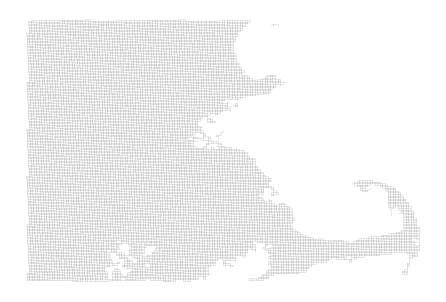

In [9]:
nx.draw(G,
        pos,              # use centroids for positions
        node_size = 0.0, # hide nodes
        width = 0.1,
        )               # show thin edges

plt.savefig('trial.png', dpi = 600)                          #show thin edges

In [10]:
file = nx.to_pandas_edgelist(G)

In [11]:
file['tractor_trailer_travel_time'] = file['weight'] * (120/100)
file['pickup_truck_travel_time'] = file['weight'] * (120/120)

In [12]:
class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight


In [13]:
graph = Graph()
edges = []

In [14]:
for i in file.iterrows():
    List = list(i)
    edges.append((List[1][0],List[1][1],List[1][3]))

In [15]:
for edge in edges:
    graph.add_edge(*edge)

In [16]:
def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

In [17]:
path = tuple(dijsktra(graph, '19TCG1685', '19TDG1600'))


In [18]:
bases = ('19TCG1685','19TCG1752')

In [19]:
#ax=nx.draw(G,
#        pos, # use centroids for positions
#        width = 0.1,
#        node_size=0) # show thin edges

#nx.draw_networkx_nodes(G,
#        pos, # use centroids for positions
#        node_size = 0.1,
#        nodelist = path,             
#        ax=ax)

#nx.draw_networkx_nodes(G,
#        pos, # use centroids for positions
#        node_size = 0.2,
#        nodelist = Path,             
#        ax=ax)
#plt.savefig('trial.png', dpi=300)

In [20]:
locations=gpd.read_file('facilities/shelters.shp').to_crs('epsg:4269')

In [21]:
locations_gdf = gpd.sjoin(game_grid,locations,how='inner',op='contains')
locations_gdf

,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,...,geometry,EAST,NORTH,index_right,ID,NAME,ADDRESS,CITY,STATE,ZIP
MGRS,,,,,,,,,,,,,,,,,,,,,
19TCH3712,CH,19T,337000mE,4712000mN,19TCH31,0.042358,0.042358,0.000110,-70.979175,42.547809,...,"POLYGON ((-70.97295 42.54341, -70.98512 42.543...",337,4712,28,250123,PEABODY VETERANS MEMORIAL HIGH SCHOOL,485 LOWELL ST,PEABODY,MA,01960
19TBH7411,BH,19T,274000mE,4711000mN,19TBH71,0.042337,0.042337,0.000110,-71.745354,42.523001,...,"POLYGON ((-71.73908 42.51865, -71.75124 42.518...",274,4711,575,251141,SOUTHEAST ELEMENTARY SCHOOL,95 VISCOLOID AVE,LEOMINSTER,MA,01453
19TBH9811,BH,19T,298000mE,4711000mN,19TBH91,0.042345,0.042345,0.000110,-71.453441,42.529627,...,"POLYGON ((-71.44718 42.52526, -71.45935 42.525...",298,4711,225,250271,SHAKER LANE ELEMENTARY SCHOOL,35 SHAKER LN,LITTLETON,MA,01460
19TCH1411,CH,19T,314000mE,4711000mN,19TCH11,0.042349,0.042349,0.000110,-71.258781,42.533631,...,"POLYGON ((-71.25254 42.52925, -71.26470 42.529...",314,4711,51,250362,VINING ELEMENTARY SCHOOL,121 LEXINGTON RD,BILLERICA,MA,01821
19TCH2611,CH,19T,326000mE,4711000mN,19TCH21,0.042352,0.042352,0.000110,-71.112760,42.536418,...,"POLYGON ((-71.10652 42.53203, -71.11869 42.531...",326,4711,539,250999,READING MEMORIAL HIGH SCHOOL,62 OAKLAND AVE,READING,MA,01867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19TDG1915,DG,19T,419000mE,4615000mN,19TDG11,0.042043,0.042043,0.000108,-69.967287,41.687206,...,"POLYGON ((-69.96121 41.68275, -69.97323 41.682...",419,4615,168,250857,CHATHAM ELEMENTARY SCHOOL,147 DEPOT RD,CHATHAM,MA,02633
19TDG0014,DG,19T,400000mE,4614000mN,19TDG01,0.042038,0.042038,0.000108,-70.195381,41.676053,...,"POLYGON ((-70.18929 41.67161, -70.20130 41.671...",400,4614,438,251090,DENNIS - YARMOUTH REGIONAL HIGH SCHOOL,210 STATION AVE,SOUTH YARMOUTH,MA,02664
19TDG0014,DG,19T,400000mE,4614000mN,19TDG01,0.042038,0.042038,0.000108,-70.195381,41.676053,...,"POLYGON ((-70.18929 41.67161, -70.20130 41.671...",400,4614,499,250535,STATION AVENUE ELEMENTARY SCHOOL,276 STATION AVE,SOUTH YARMOUTH,MA,02664


In [22]:
with open('locations.csv', 'w') as file:
    file.write('locations_gdf')

In [23]:
#Path = tuple(locations_gdf.index)

In [24]:
#paths = []


In [25]:
#count = 1
#for i in Path:
#    start = time.time()
#    calc_path = tuple(dijsktra(graph, bases[0], i))
#    paths.append(list(calc_path))
#    if count % 10 == 0:
#        stop = time.time()
#        print(count, stop-start)
#    count += 1

In [26]:
#with open('newpaths.txt', 'w') as f:
#    f.write(json.dumps(paths))

In [27]:
with open('newpaths.txt', 'r') as f:
    new_paths = json.loads(f.read())

In [63]:
locations_gdf = locations_gdf.reset_index()

In [38]:
range_east = max(locations_gdf['EAST']) - min(locations_gdf['EAST'])

In [39]:
range_north = max(locations_gdf['NORTH']) - min(locations_gdf['NORTH'])

In [37]:
min(locations_gdf['EAST'])

273

In [157]:
 max(locations_gdf['EAST'])

419

In [109]:
close_nodes = []
initial_east = 273
for i in range(10):
    for j in range(initial_east, initial_east + int(range_east/10)):
        close_nodes.append(list(locations_gdf.loc[locations_gdf['EAST'] == j]['MGRS']))
    initial_east =  initial_east + int(range_east/10)
    close_nodes.append('BREAK')



In [66]:
hi = []
hi.append([])

In [67]:
hi[0].append(1)

In [68]:
hi

[[1]]

In [84]:
nodes.append(list(locations_gdf.loc[locations_gdf['EAST'] == 273]['MGRS']))

In [83]:
nodes = []

In [85]:
nodes

[['19TBG7359', '19TBG7332']]

In [124]:
for i in range(len(close_nodes)):
    if close_nodes[i] == "BREAK":
        print(i)

14
29
44
59
74
89
104
119
134
149


In [138]:
List = ['a','b','c','d','e','f','g']

In [141]:
New = List[:4]

In [142]:
New

['a', 'b', 'c', 'd']

In [143]:
new_list = close_nodes[:14]

In [162]:
#locations_gdf.loc[locations_gdf['MGRS'] == new_list[0][0]]

In [163]:
#locations_gdf.loc[locations_gdf['MGRS'] == new_list[13][0]]

In [164]:
new_list = list(itertools.chain(*new_list))

'19TCG1685'